# Permeability anisotropy

In this tutorial we investigate demonstrate how the two-point flux approximation (TPFA) breaks down for anisotropic permeability tensors for single-phase flow problems. <br>

We refer to the Get started tutorial for definitions of the problem, domain and data quantities. For this example, we will use pure Dirichlet conditions, $p_b = 0$ $f = 1$ and different anisotropic permeabilities defined below.

## Import basic modules

Before creating the grid we import some modules.

In [59]:
# Standard modules
import numpy as np
import scipy.sparse as sps

# Module for structured grid and plot with matplotlib
from porepy.grids import structured
from porepy.viz import plot_grid

# Modules for the parameters
from porepy.params import tensor
from porepy.params.data import Parameters
from porepy.params.bc import BoundaryCondition

# Module for geometical manipulations
from porepy.utils import comp_geom

# Modules for discretization
from porepy.numerics.fv import tpfa, mpfa, source

# Module for error computation
from porepy.utils.errors import error

## Creation of the grid

We create first a Cartesian grid and compute its geometrical quantities.

In [2]:
Nx = Ny = 10                                          
g = structured.CartGrid([Nx, Ny], [2, 2])
g.compute_geometry()

We plot the grid using the interface with matplotlib.

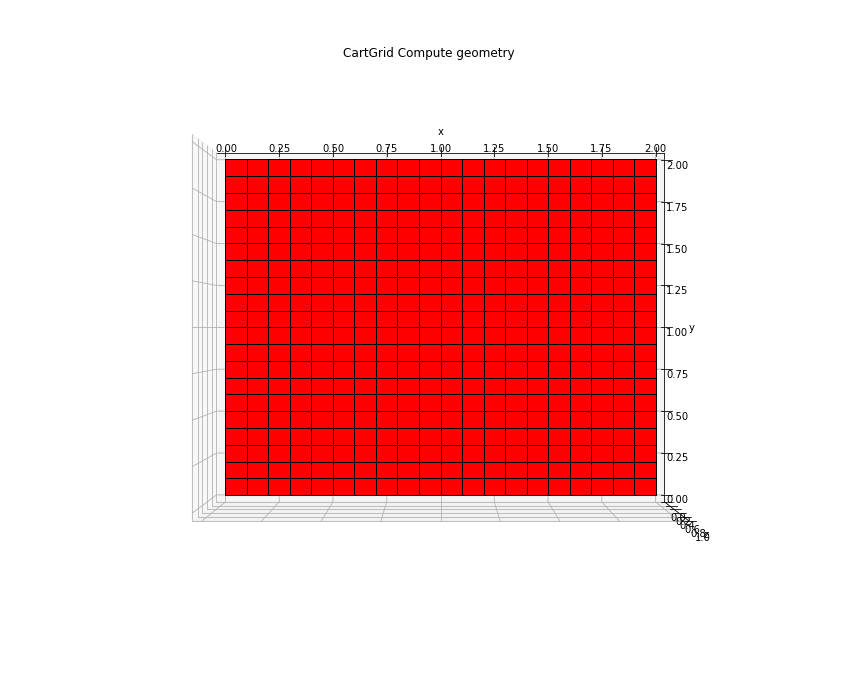

In [3]:
plot_grid.plot_grid(g, figsize=(15, 12))

# Define the problem data

We declare the permeability matrix $K$, the scalar source term $f$, and the boundary conditions.

In [21]:
# Permeability
def set_permeability(r_k, theta):
    kxx = 1
    kyy = r_k
    k = np.array([[kxx, 0], [0, kyy]])
    k1 = np.array([[kxx, 0, 0], [0, kyy, 0], [0, 0, 0]])
    R = comp_geom.rot(theta, [0, 0, 1])[:2, :2]
    k = np.dot(np.dot(R, k), R.T)
    return tensor.SecondOrder(g.dim, k[0, 0] * np.ones(g.num_cells), kyy=k[1, 1], kxy=k[0, 1])

In [22]:
# Unitary scalar source already integrated in each cell
f = g.cell_volumes

# Boundary conditions
b_faces = g.tags['domain_boundary_faces'].nonzero()[0]
bc = BoundaryCondition(g, b_faces, ['dir']*b_faces.size)
bc_val = np.zeros(g.num_faces)

Once all the data are created we group them in a dictionary, where the keyword `"flow"` represents the physical process considered.

In [38]:
param = Parameters(g)
param.set_tensor("flow", set_permeability(10, np.pi/4))
param.set_bc("flow", bc)
param.set_bc_val("flow", bc_val)
param.set_source("flow", f)
data = {'param': param}

## Problem discretization and solution

In this section we apply the different discretizations and solve the problem.

### Two-point flux approximation

The two-point flux approximation solves the single-phase flow problem in the primal formulation. The pressure is directly computed.

In [46]:
tpfa_discretizer = tpfa.Tpfa("flow")
A, b_flow = tpfa_discretizer.matrix_rhs(g, data)

source_discretizer = source.Integral("flow")
_, b_source = source_discretizer.matrix_rhs(g, data)

p = sps.linalg.spsolve(A, b_flow + b_source) 

To represent the solution:

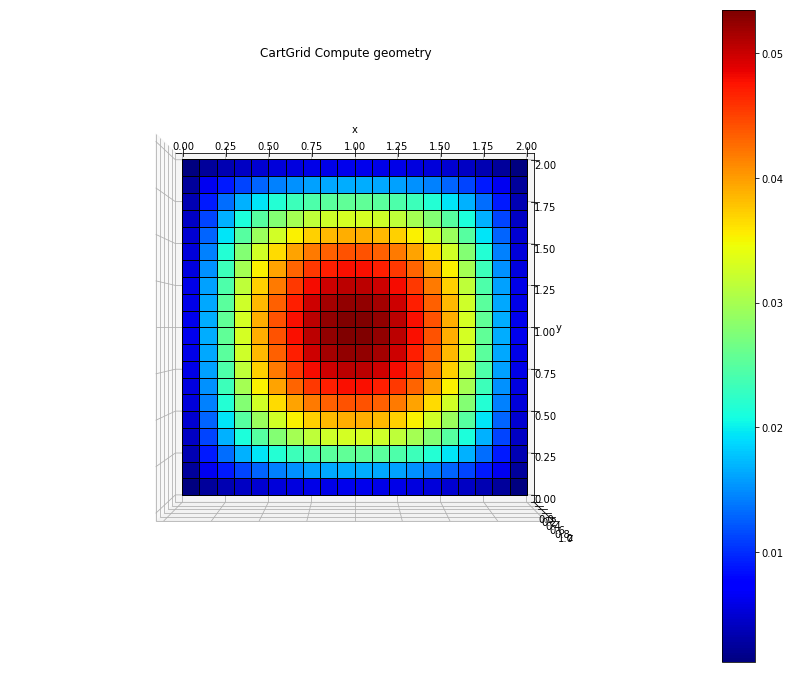

In [47]:
plot_grid.plot_grid(g, p, figsize=(15, 12))

Consistency check:

In [48]:
print(np.sum(p)) #assert np.isclose(np.sum(p), 10.321952248)

10.321952248


### Multi-point flux approximation 

The multi-point flux approximation solves the single-phase flow problem in the primal formulation. The pressure is directly computed.

In [49]:
mpfa_discretizer = mpfa.Mpfa("flow")
A, b_flow = mpfa_discretizer.matrix_rhs(g, data)

p_mpfa = sps.linalg.spsolve(A, b_flow + b_source)

To represent the solution:

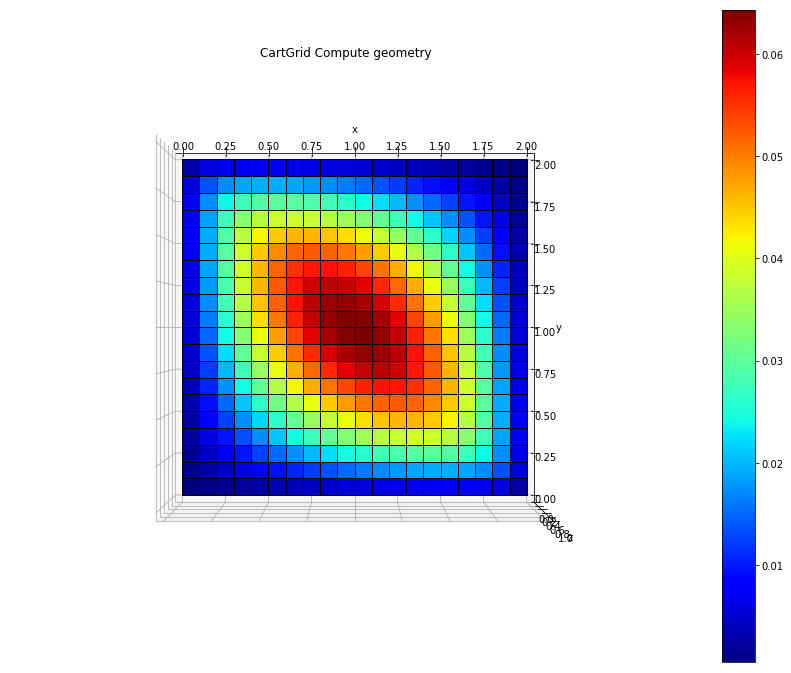

In [50]:
plot_grid.plot_grid(g, p_mpfa, figsize=(15, 12))

Consistency check:

In [51]:
print(np.sum(p)) #assert np.isclose(np.sum(p), 11.2683078949)

10.321952248


## Comparison of solutions

In addition to the two pressure plots above, we compare the solutions by plotting the absolute value of the cell-wise difference between the solutions and the $L^2$ errors. In both cases, we normalize by dividing through the value range of the reference solution, since the Darcy problem is in general gradient driven.

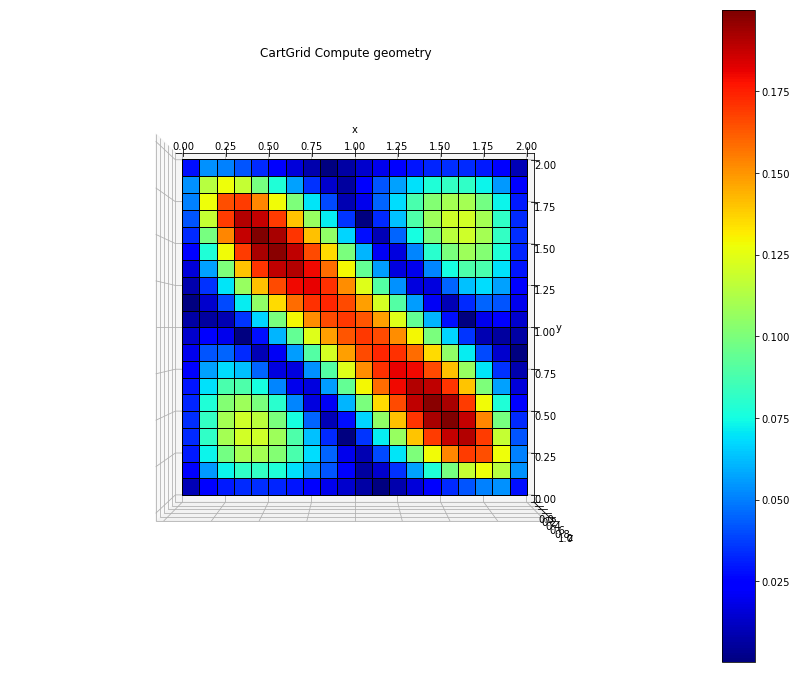

L2 error:  0.211285559919


In [62]:
d_p = np.max(p_mpfa) - np.min(p_mpfa)
absolute_difference = np.absolute(p - p_mpfa)/d_p
plot_grid.plot_grid(g, absolute_difference, figsize=(15, 12))

L2_error = error.error_L2(g, p_mpfa, p)
print('L2 error: ', L2_error)